In [1]:
import pandas as pd
import numpy as np

data_location = "../data/data_prepared.pkl"


In [2]:
output_shape = 77
raw_data = pd.read_pickle(data_location).astype(float)
raw_data = raw_data.iloc[:,:output_shape]

In [3]:
raw_data.shape

(2945, 77)

In [4]:
from sklearn. preprocessing import StandardScaler
def generate_time_features(X):
        # hour, month, day, dayOfWeek, ISvacation,  ISweekend
        X = X.copy()
        X["Hour"] = X.index.hour
        X["Month"] = X.index.month
        X["Day"] = X.index.day
        X["weekday"] = X.index.weekday
        X["IsWeekend"] = np.array(map(lambda i:0 if i <5 else 1,X.index.weekday))
        return X
features = generate_time_features(raw_data).astype(float)
features  = features/np.mean(features,axis= 0)
targets = raw_data.astype(float)

In [5]:
features.shape, targets.shape

((2945, 82), (2945, 77))

In [6]:
import keras
sampling_rate = 1
sequence_length = 168
forecast_steps = 1
delay = sampling_rate * (sequence_length + forecast_steps - 1)
batch_size = 128



In [7]:
num_row = raw_data.shape[0] - delay
num_train_samples = int(0.8 * num_row)
num_val_samples = int(0.1 * num_row)
num_test_samples = num_row- num_train_samples - num_val_samples

In [8]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
  
val_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
  
test_dataset = keras.utils.timeseries_dataset_from_array(
    features.iloc[:-delay,:],
    targets=targets.iloc[delay:,:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [9]:
for inputs, targets in train_dataset:
    print(inputs.shape, targets.shape)

(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(128, 168, 82) (128, 77)
(6, 168, 82) (6, 77)


In [10]:
n = 0
for inputs, targets in train_dataset:
    print(inputs[1,:,0])
    print(targets[0,0])
    if n>=1:
        break
    n+=1

tf.Tensor(
[0.         0.08895668 0.14826114 0.11860891 0.26687005 0.80061016
 0.71165348 0.85991462 0.65234902 0.62269679 1.27504581 1.77913369
 2.43148271 2.01635152 2.16461266 1.77913369 0.         0.
 0.         0.         0.         0.         0.         0.11860891
 0.2075656  0.32617451 0.53374011 0.32617451 0.50408788 0.9488713
 0.91921907 0.9488713  1.09713244 1.1564369  1.03782799 1.74948146
 1.98669929 2.75765722 2.37217826 0.02965223 0.         0.
 0.         0.         0.         0.         0.         0.02965223
 0.08895668 0.26687005 0.59304456 0.56339234 0.41513119 0.62269679
 0.88956685 0.97852353 0.9488713  1.33435027 1.66052478 2.34252603
 2.90591836 1.83843815 1.8977426  0.08895668 0.         0.
 0.         0.         0.         0.         0.         0.05930446
 0.08895668 0.32617451 0.44478342 0.59304456 1.27504581 1.00817576
 1.27504581 1.74948146 2.1053082  2.40183048 3.23209287 1.95704706
 1.74948146 2.04600375 1.48261141 0.         0.         0.
 0.         0.   

In [18]:
def get_predict_and_true(model,test_dataset):
    n = 0
    for inputs,targets in test_dataset:
        input_sample = inputs
        target_sample = targets
        n+=1
        if n>=1:
            break
    y_pred = model.predict(input_sample)
    y_true = target_sample
    return y_true, y_pred
import matplotlib.pyplot as plt
def calculate_smape(y_true, y_pred):
   
    #Ensure no division by zero
    epsilon = np.finfo(np.float64).eps
    
    # Calculate the absolute differences
    absolute_differences = np.abs(y_pred - y_true)
    
    # Calculate the denominators
    denominators = (np.abs(y_true) + np.abs(y_pred)) / 2 + epsilon
    
    # Calculate individual sMAPE values
    smape_values = (absolute_differences / denominators) 
    smape = np.mean(smape_values,axis=0) * 100

    return smape
def cal_metrics(y_true,y_pred):
    smape = calculate_smape(y_true,y_pred)
    mse = np.mean((y_pred - y_true)**2,axis = 0)
    mae = np.mean(np.abs(y_pred - y_true),axis=0)
    return [mse,mae,smape]

def plot_result(y_true,y_pred,area_index,model_name = "None"):
    y_pred[y_pred<1] = 0
    x = range(len(y_true))
    num_area = len(area_index)
    plot_index = 1
    plt.figure(figsize=(12,20))
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    for i in area_index:
        area_predict = y_pred[:,i]
        area_true = y_true[:,i]
        area_name = raw_data.columns[i]

        metrics = cal_metrics(y_true,y_pred)
        area_diff = area_predict - area_true
        plt.subplot(num_area,1,plot_index)
        plt.title(f"{area_name} mse: {metrics[0][i]:.2f} mae: {metrics[1][i]:.2f} smape: {metrics[2][i]:.2f}")
        plt.plot(x,area_predict,label = "predict")
        plt.plot(x,area_true,label = "real")
        plt.plot(x,area_diff,label = "difference")
        plt.legend()

        plot_index +=1
    plt.tight_layout()
    plt.suptitle(model_name,y = 1.02)

    
    plt.show()


In [19]:
# Dense model
from tensorflow import keras 
from keras import layers
  
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",          
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
         
         
       

Epoch 1/100


17/17 [==============================] - 1s 36ms/step - loss: 133.8176 - mae: 5.0916 - val_loss: 17.9025 - val_mae: 1.5405
Epoch 2/100
17/17 [==============================] - 0s 10ms/step - loss: 102.3715 - mae: 4.3854 - val_loss: 13.0833 - val_mae: 1.9678
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 73.0777 - mae: 4.0087 - val_loss: 8.2755 - val_mae: 1.4791
Epoch 4/100
17/17 [==============================] - 0s 8ms/step - loss: 54.2185 - mae: 3.5781 - val_loss: 6.3000 - val_mae: 1.3878
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 36.6466 - mae: 2.9426 - val_loss: 5.3946 - val_mae: 1.2515
Epoch 6/100
17/17 [==============================] - 0s 8ms/step - loss: 29.5361 - mae: 2.5671 - val_loss: 5.3355 - val_mae: 1.1833
Epoch 7/100
17/17 [==============================] - 0s 9ms/step - loss: 29.5713 - mae: 2.6689 - val_loss: 5.1524 - val_mae: 1.1293
Epoch 8/100
17/17 [==============================] - 0s 6ms/step - loss: 25.7762 -

4/4 [==============================] - 0s 1ms/step


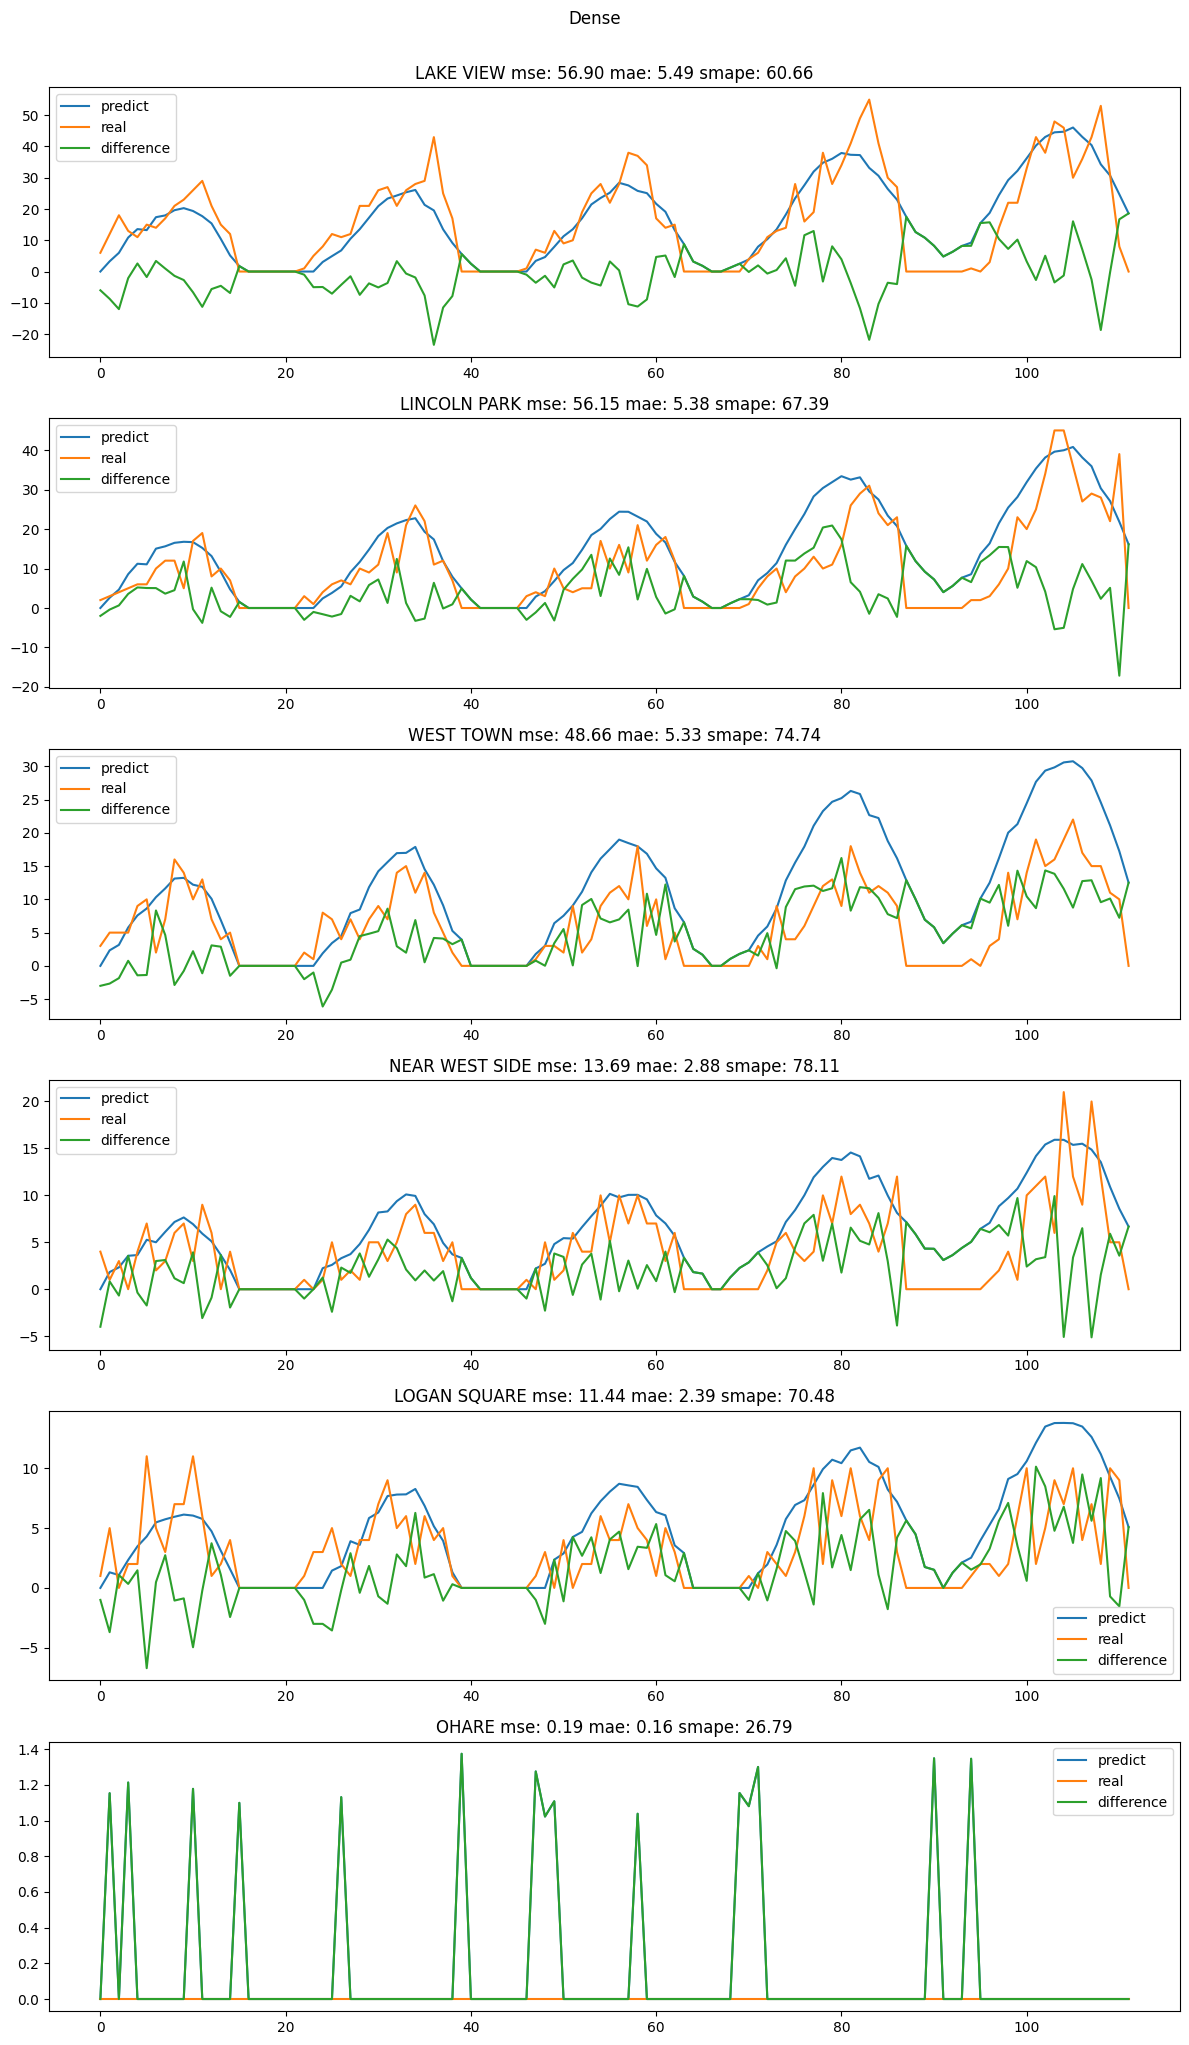

In [20]:
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_index = np.append(np.arange(5), -1)
plot_result(y_true,y_pred,plot_index,"Dense")  

In [21]:
# CONV 1D
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
17/17 [==============================] - 3s 75ms/step - loss: 111.7942 - mae: 4.3874 - val_loss: 13.3482 - val_mae: 1.7061
Epoch 2/100
17/17 [==============================] - 0s 17ms/step - loss: 71.7202 - mae: 3.8377 - val_loss: 11.0196 - val_mae: 1.4929
Epoch 3/100
17/17 [==============================] - 0s 9ms/step - loss: 54.5791 - mae: 3.3423 - val_loss: 9.6913 - val_mae: 1.3681
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 47.7178 - mae: 3.0992 - val_loss: 9.0358 - val_mae: 1.3112
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 44.8958 - mae: 2.9647 - val_loss: 8.5585 - val_mae: 1.2711
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 43.0338 - mae: 2.8701 - val_loss: 8.1644 - val_mae: 1.2476
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 41.4721 - mae: 2.7865 - val_loss: 7.7807 - val_mae: 1.2299
Epoch 8/100
17/17 [==============================] - 0s 9ms/step - lo

4/4 [==============================] - 0s 3ms/step


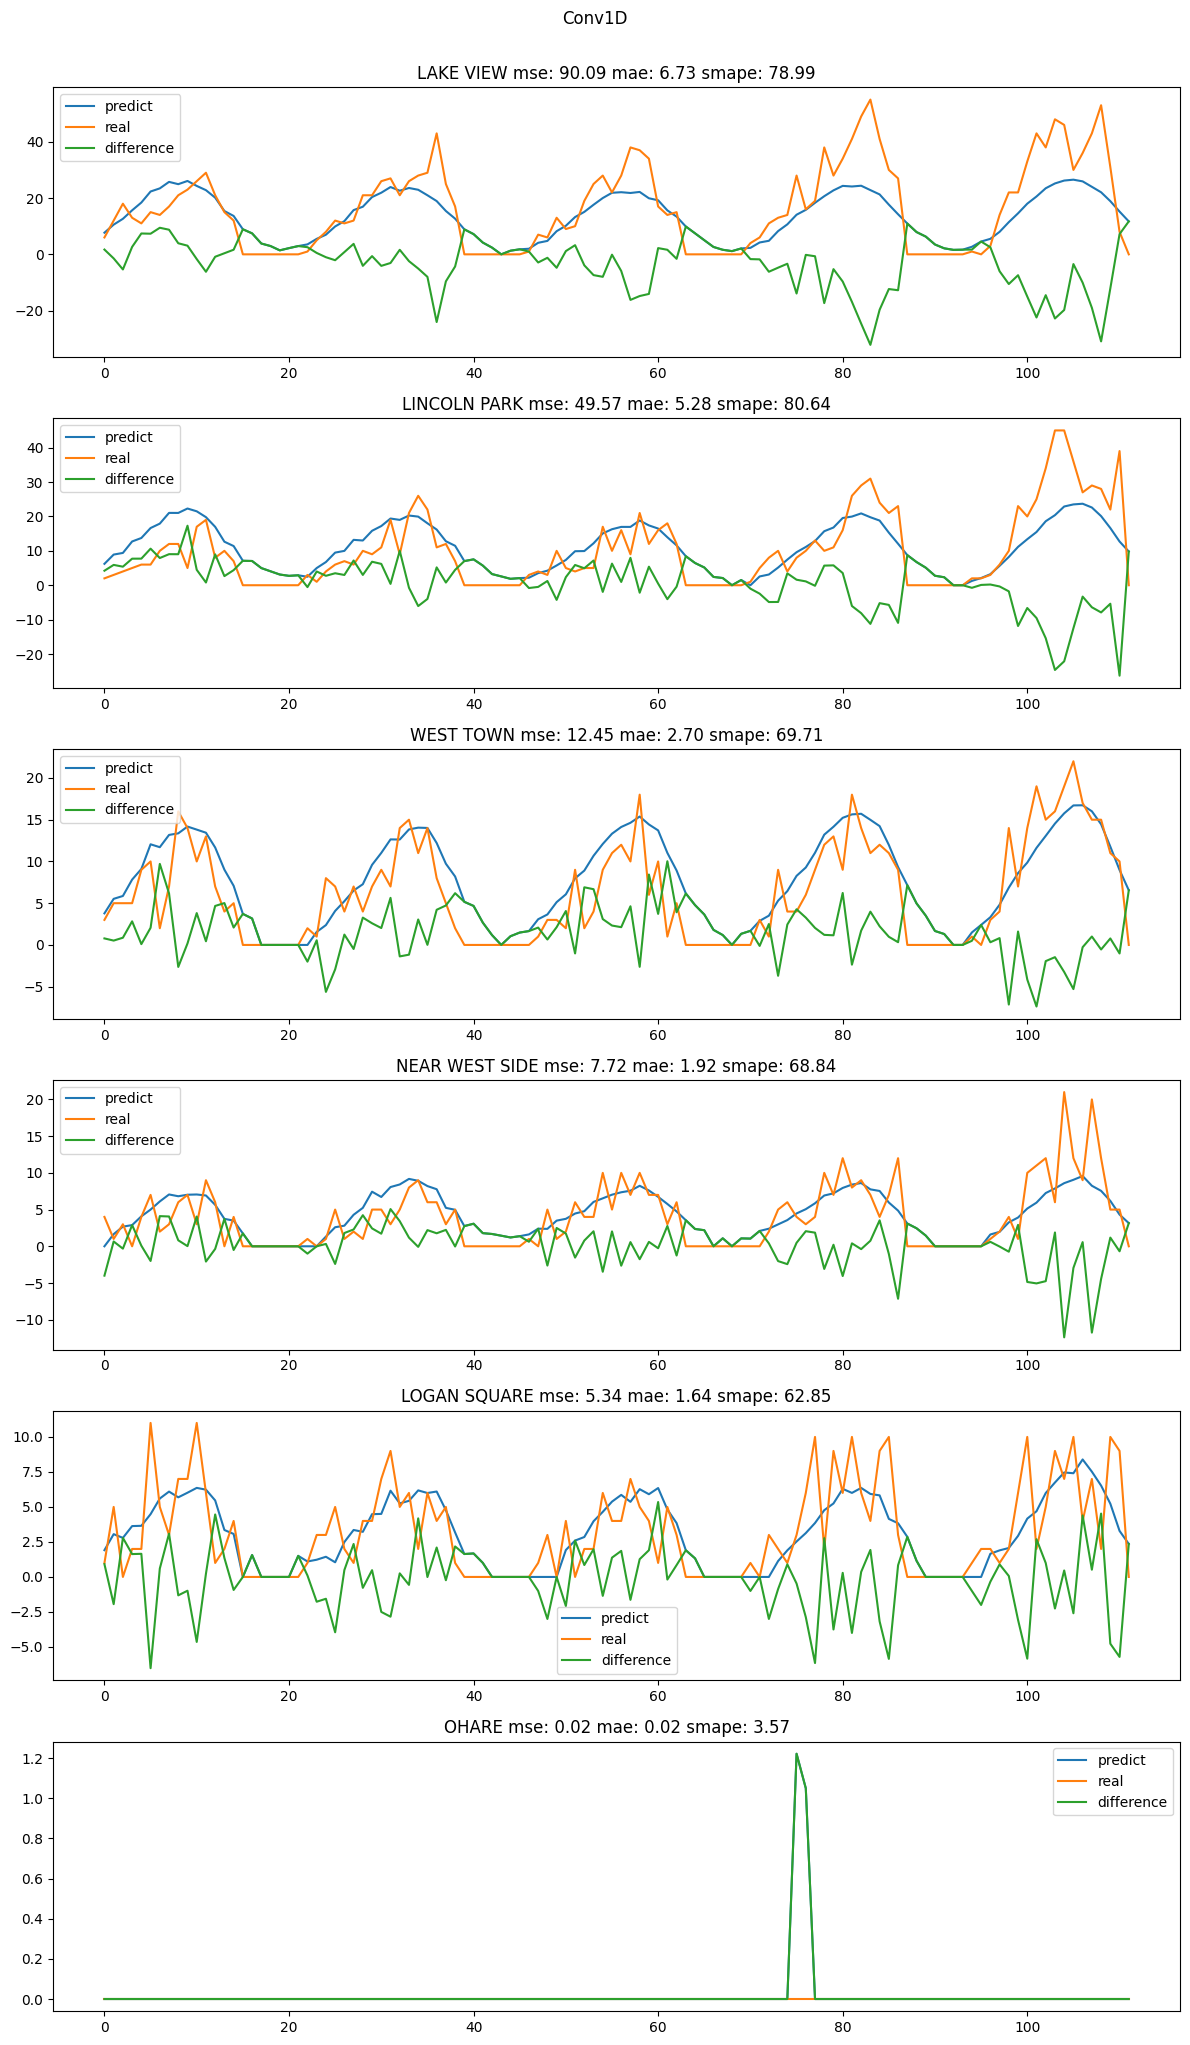

In [29]:
model = keras.models.load_model("jena_conv.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,plot_index,"Conv1D")  

In [23]:
# LSTM
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.LSTM(64)(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
17/17 [==============================] - 2s 73ms/step - loss: 131.5114 - mae: 3.3843 - val_loss: 16.3938 - val_mae: 1.4347
Epoch 2/100
17/17 [==============================] - 0s 15ms/step - loss: 121.4827 - mae: 3.2891 - val_loss: 15.2145 - val_mae: 1.5214
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 116.9104 - mae: 3.2333 - val_loss: 14.3241 - val_mae: 1.5166
Epoch 4/100
17/17 [==============================] - 0s 15ms/step - loss: 113.1094 - mae: 3.1427 - val_loss: 13.4267 - val_mae: 1.4613
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 109.4886 - mae: 3.0434 - val_loss: 12.5818 - val_mae: 1.4076
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 106.0923 - mae: 2.9548 - val_loss: 11.8160 - val_mae: 1.3559
Epoch 7/100
17/17 [==============================] - 0s 15ms/step - loss: 102.9298 - mae: 2.8760 - val_loss: 11.1143 - val_mae: 1.3016
Epoch 8/100
17/17 [==============================] - 0s

4/4 [==============================] - 0s 5ms/step


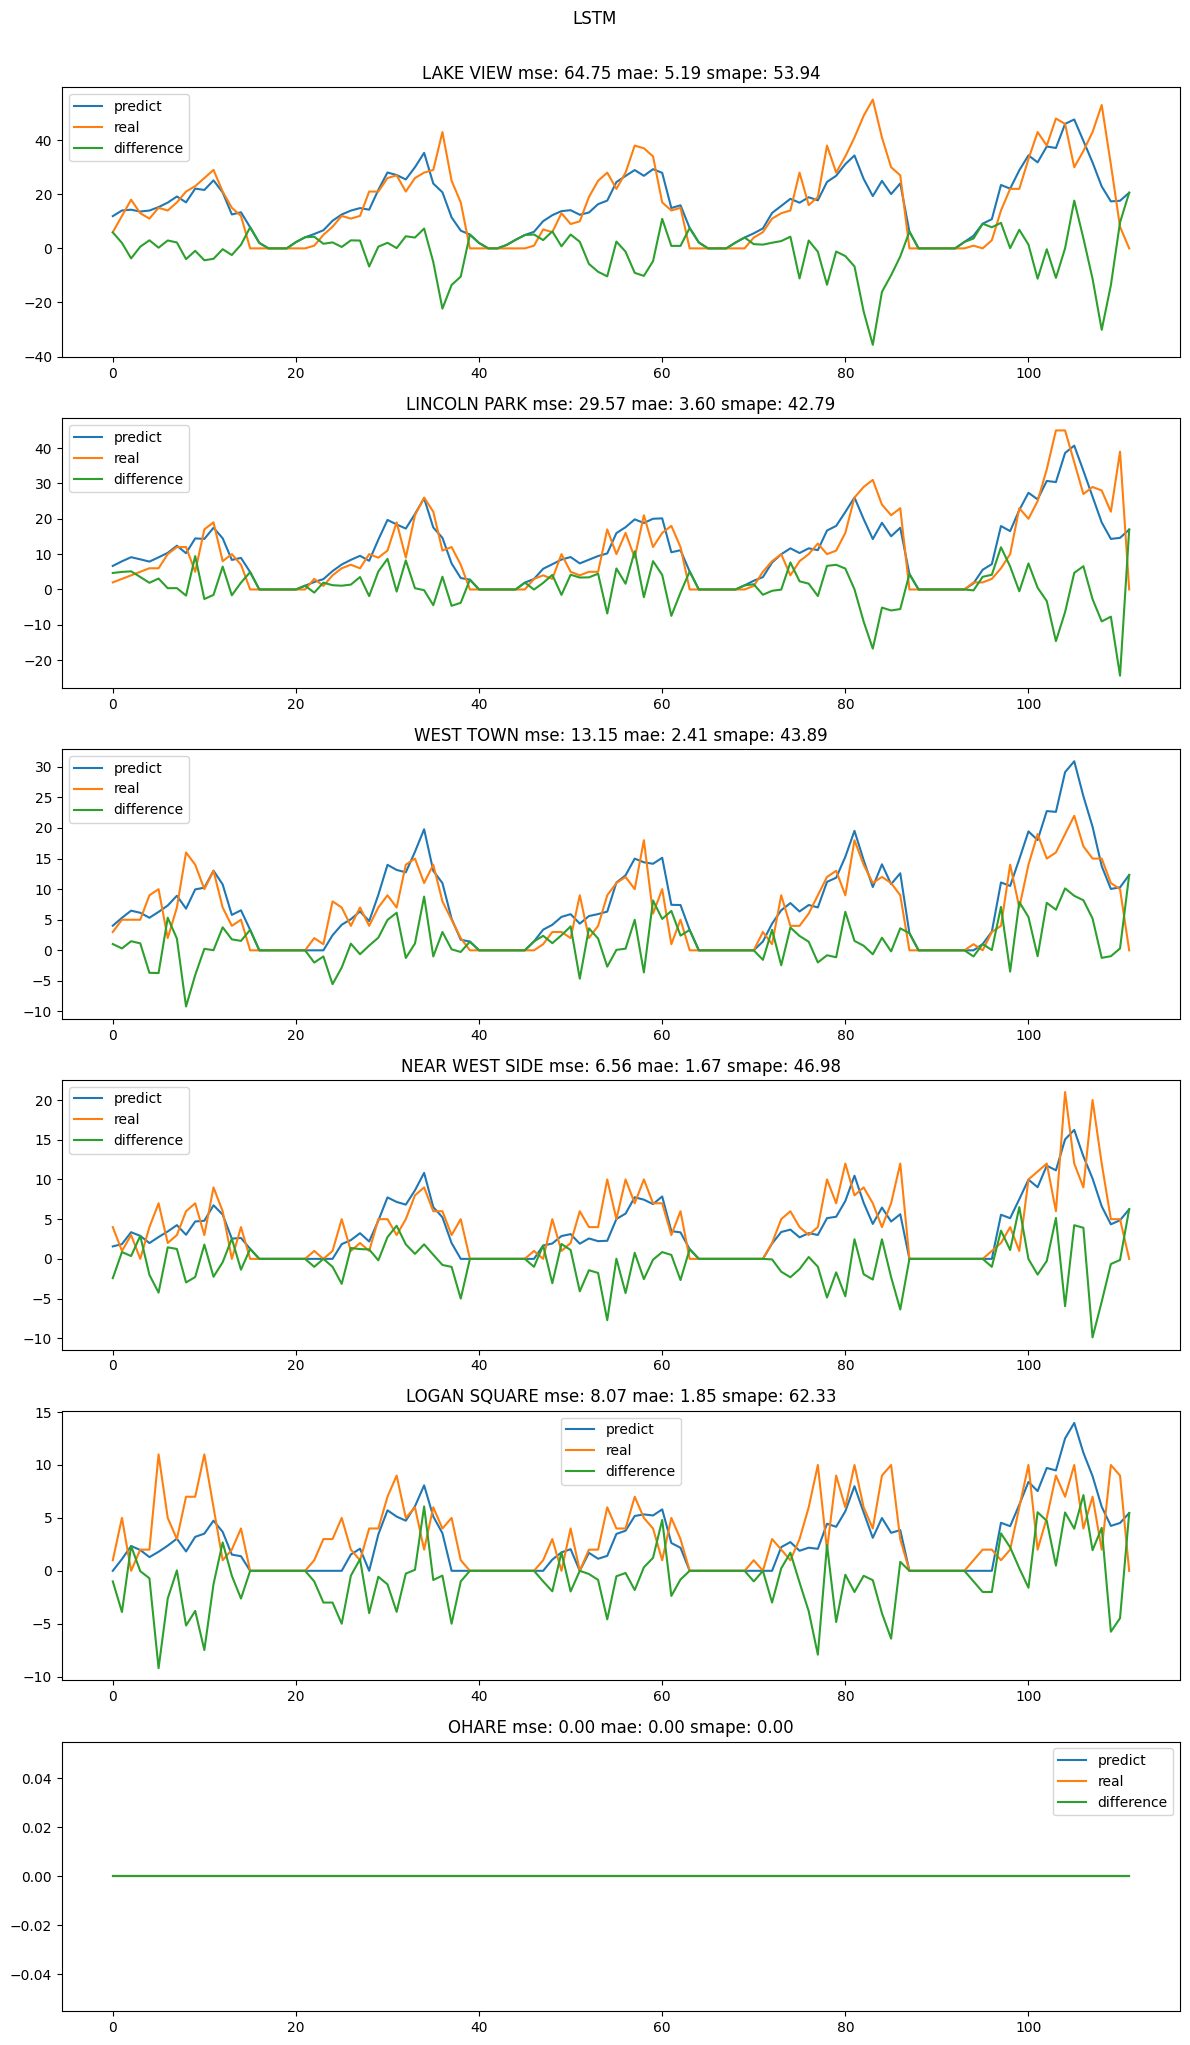

In [24]:
model = keras.models.load_model("_lstm.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,plot_index,"LSTM") 

In [25]:
# gru
inputs = keras.Input(shape=(sequence_length, features.shape[-1]))
x = layers.GRU(64)(inputs)
x = layers.Flatten()(x)
outputs = layers.Dense(output_shape)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("_gru.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/100
17/17 [==============================] - 2s 47ms/step - loss: 133.2862 - mae: 3.4114 - val_loss: 16.8596 - val_mae: 1.4110
Epoch 2/100
17/17 [==============================] - 1s 39ms/step - loss: 123.6770 - mae: 3.2923 - val_loss: 15.2877 - val_mae: 1.4592
Epoch 3/100
17/17 [==============================] - 1s 39ms/step - loss: 118.5942 - mae: 3.1576 - val_loss: 14.0363 - val_mae: 1.3636
Epoch 4/100
17/17 [==============================] - 1s 38ms/step - loss: 114.2818 - mae: 3.0075 - val_loss: 13.0392 - val_mae: 1.3043
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 110.4609 - mae: 2.9072 - val_loss: 12.2492 - val_mae: 1.2767
Epoch 6/100
17/17 [==============================] - 1s 37ms/step - loss: 107.0516 - mae: 2.8409 - val_loss: 11.5711 - val_mae: 1.2545
Epoch 7/100
17/17 [==============================] - 1s 38ms/step - loss: 103.9182 - mae: 2.7870 - val_loss: 10.9584 - val_mae: 1.2299
Epoch 8/100
17/17 [==============================] - 1s

4/4 [==============================] - 0s 4ms/step


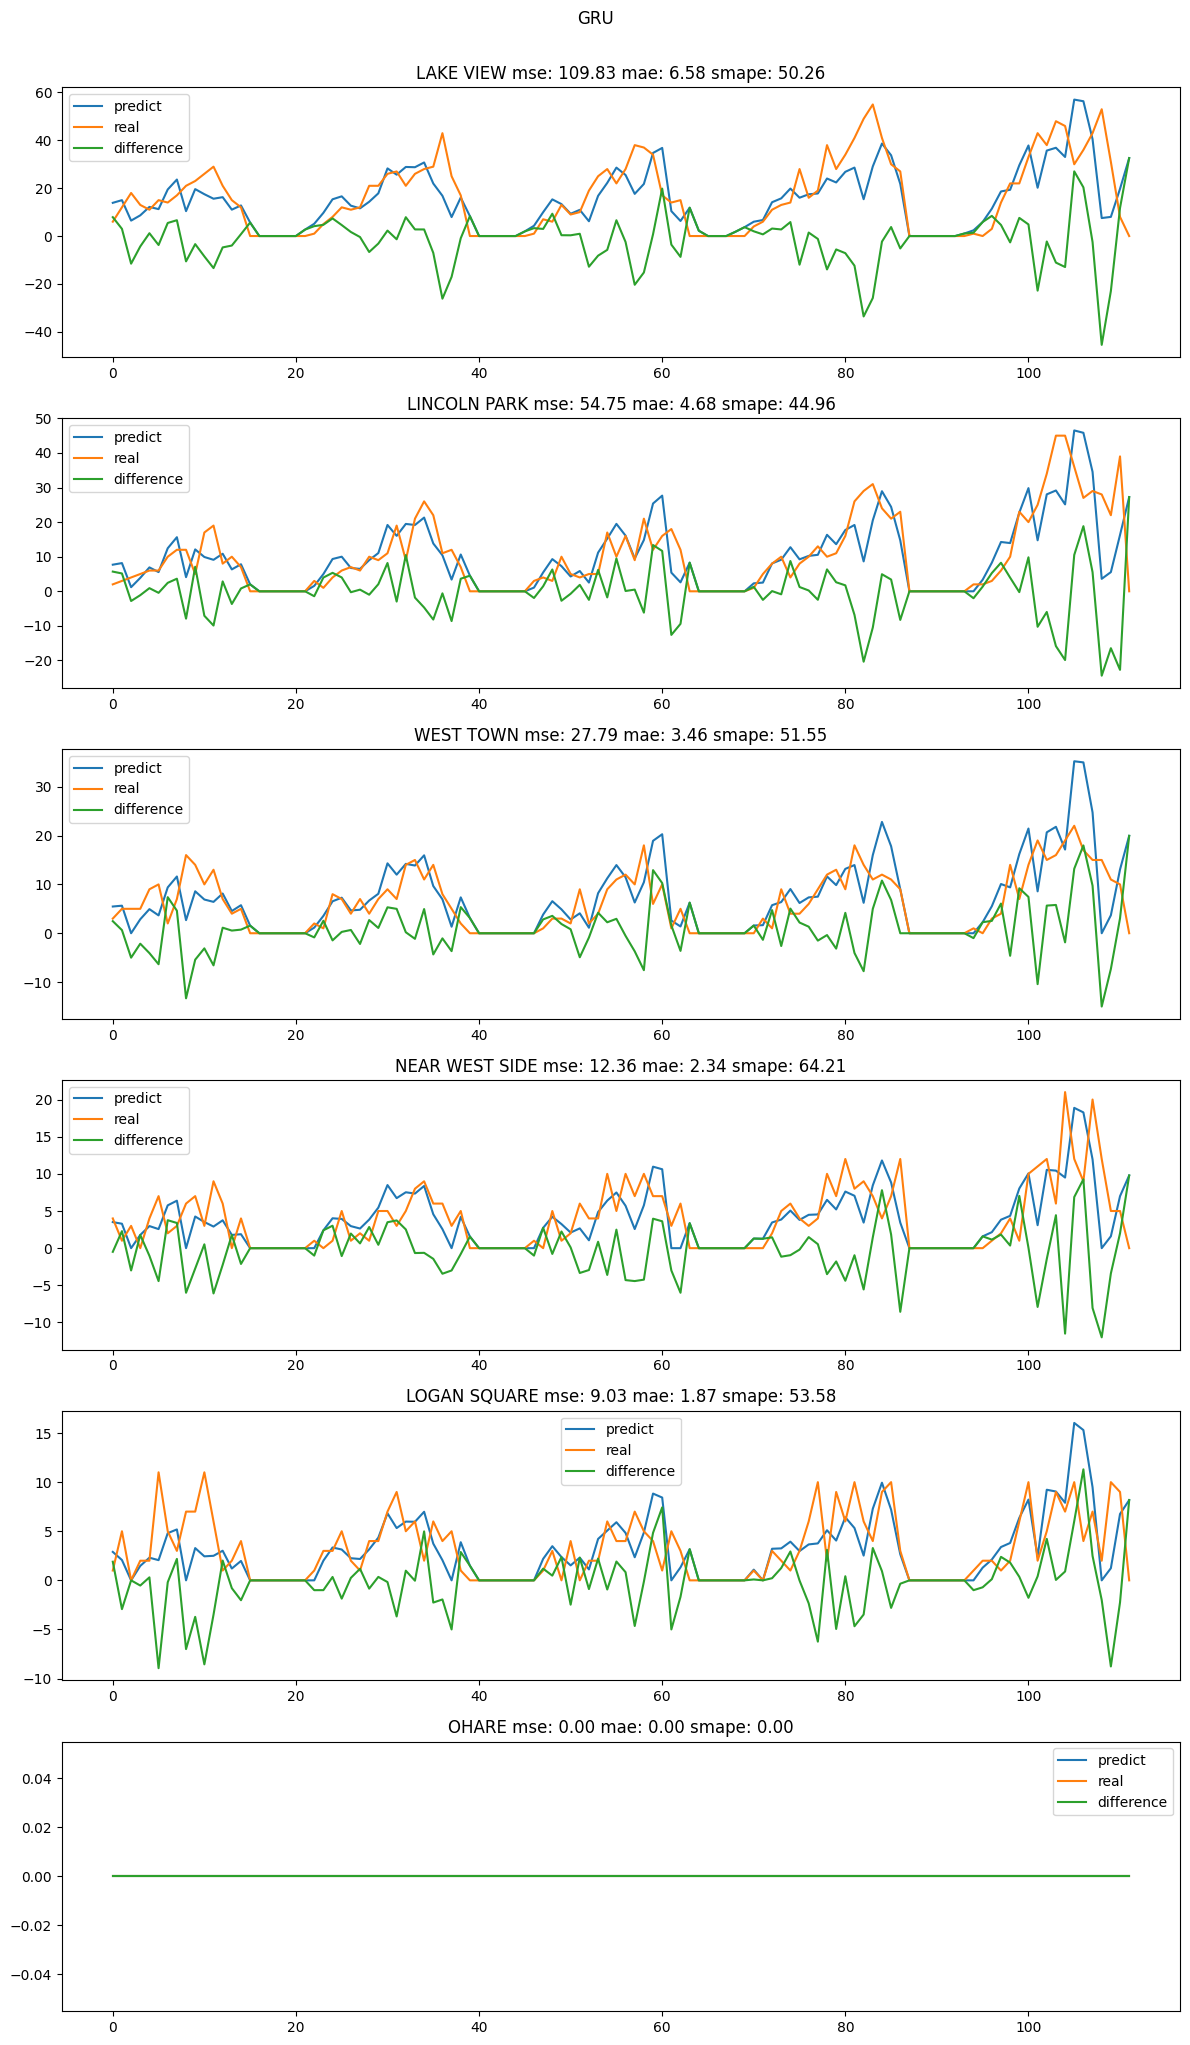

In [26]:
model = keras.models.load_model("_gru.keras")
model.evaluate(test_dataset)
y_true, y_pred = get_predict_and_true(model, test_dataset)
plot_result(y_true,y_pred,plot_index,"GRU") 

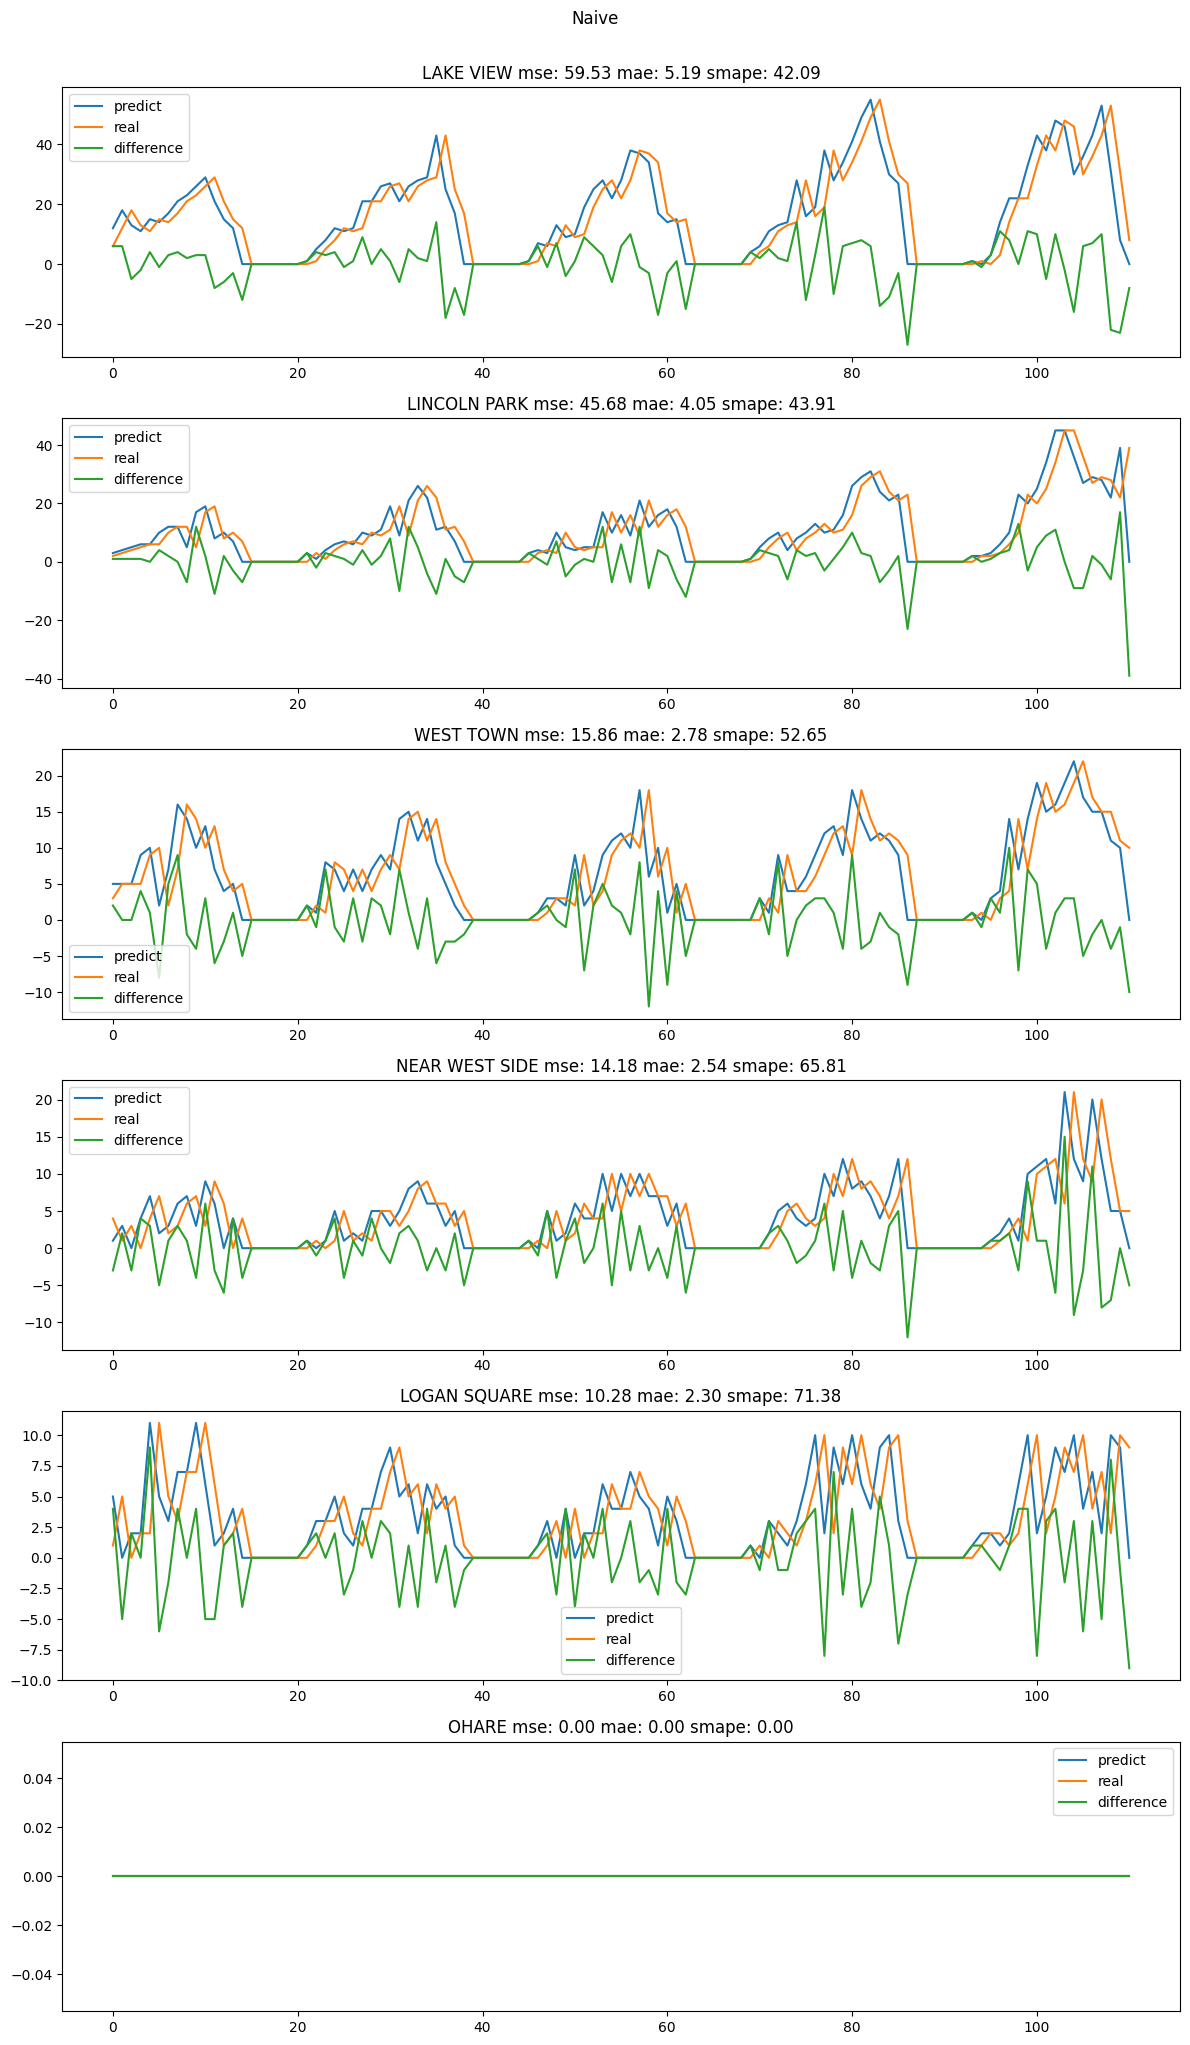

In [27]:
y_true_naive = y_true.numpy()
plot_result(y_true_naive[:-1,:],y_true_naive[1:,:],plot_index,model_name="Naive")
m = cal_metrics(y_true_naive[:-1,:],y_true_naive[1:,:])


In [28]:
for i in m:
    print(i.sum()/len(i))
    

3.18954018954019
0.700947700947701
48.732536671770085
